## Uniform Distribution

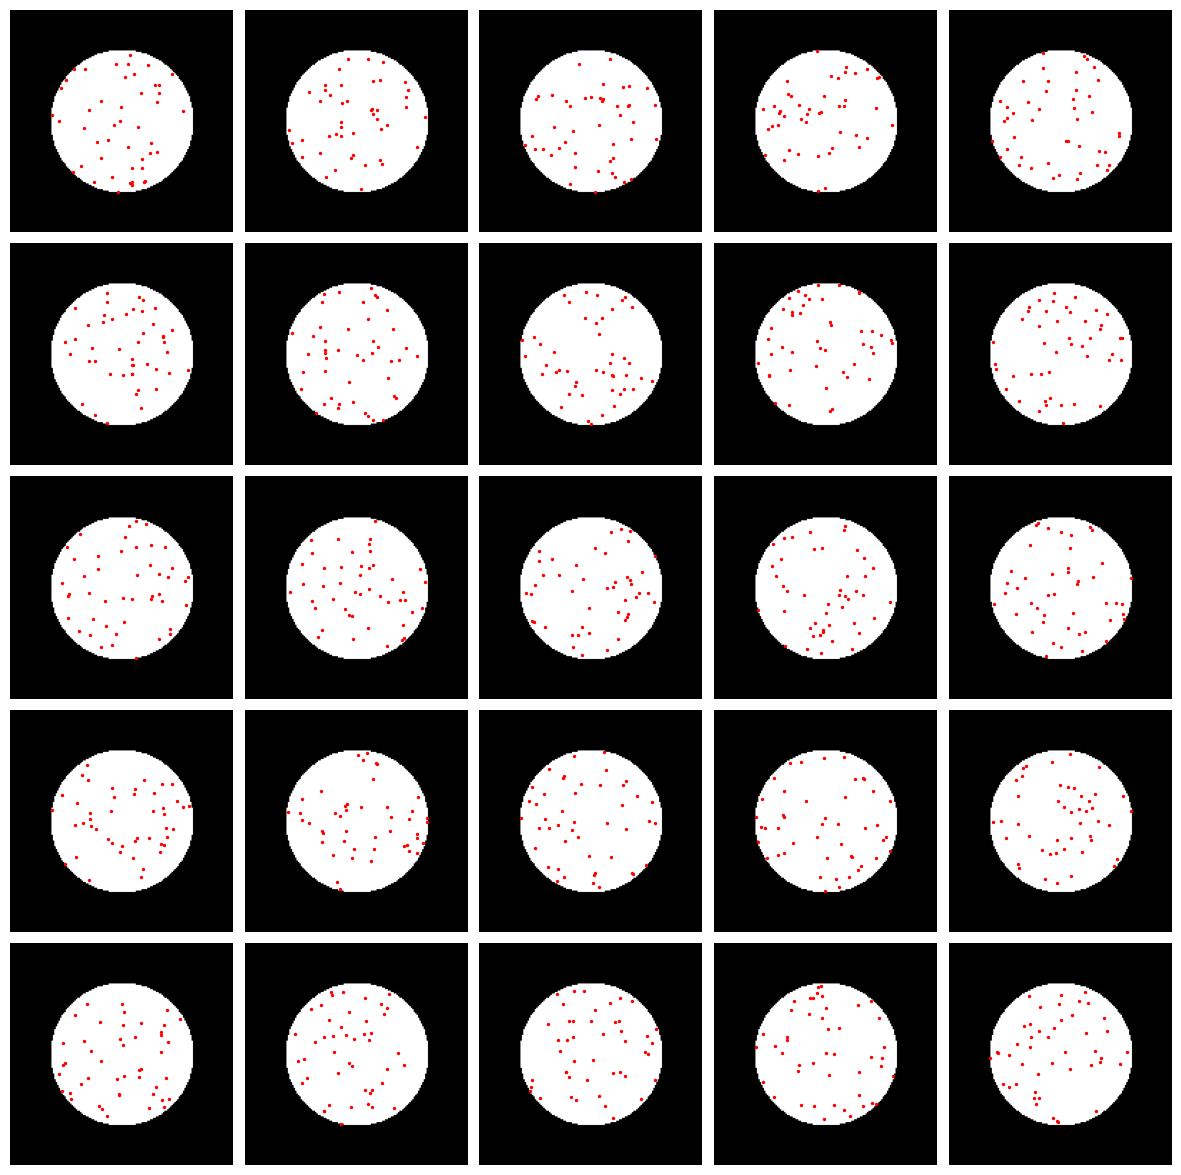

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse
import pickle

# Image dimensions
height, width = 256, 256
center_y, center_x = height // 2, width // 2
a, b = 50, 50  # Major and minor axes

# Create a blank image
image = np.zeros((height, width), dtype=np.uint8)

# Generate ellipse
rr, cc = ellipse(center_y, center_x, b, a, shape=image.shape)
image[rr, cc] = 1

# Function to generate random spots using a uniform distribution within an ellipse
def generate_spots_ellipse(num_samples=46):
    spots = []
    while len(spots) < num_samples:
        x = np.random.uniform(center_x - a, center_x + a)
        y = np.random.uniform(center_y - b, center_y + b)
        if (x - center_x)**2 / a**2 + (y - center_y)**2 / b**2 <= 1:
            spots.append([x, y])
    return np.array(spots)

# Dictionaries to store the locations and parameters
locations_dict = {}
parameters_dict = {}

# Generate and store samples
index = 1
for repeat in range(100):
    for _ in range(10):  # Adjust as needed for number of samples per repeat
        spots = generate_spots_ellipse(num_samples=46)
        locations_dict[f'distribution_{index}'] = spots
        parameters_dict[f'distribution_{index}'] = {'shape': 'ellipse', 'num_samples': 46}
        index += 1

# Display example distributions
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    ax[i//5, i%5].imshow(image[50:206 ,50:206], cmap='gray')
    spots = locations_dict[f'distribution_{i+1}']
    ax[i//5, i%5].scatter(spots[:, 0]-50, spots[:, 1]-50, c='red', s=2)
    ax[i//5, i%5].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust as needed (smaller values reduce spacing)
plt.show()

# Save locations_dict and parameters_dict to files
with open('/data/krishnendu/ripley_paper/generated_spots_25r/uniform_ellipse_locations_dict.pkl', 'wb') as f:
    pickle.dump(locations_dict, f)
with open('/data/krishnendu/ripley_paper/generated_spots_25r/uniform_ellipse_parameters_dict.pkl', 'wb') as f:
    pickle.dump(parameters_dict, f)


## Single Gaussian

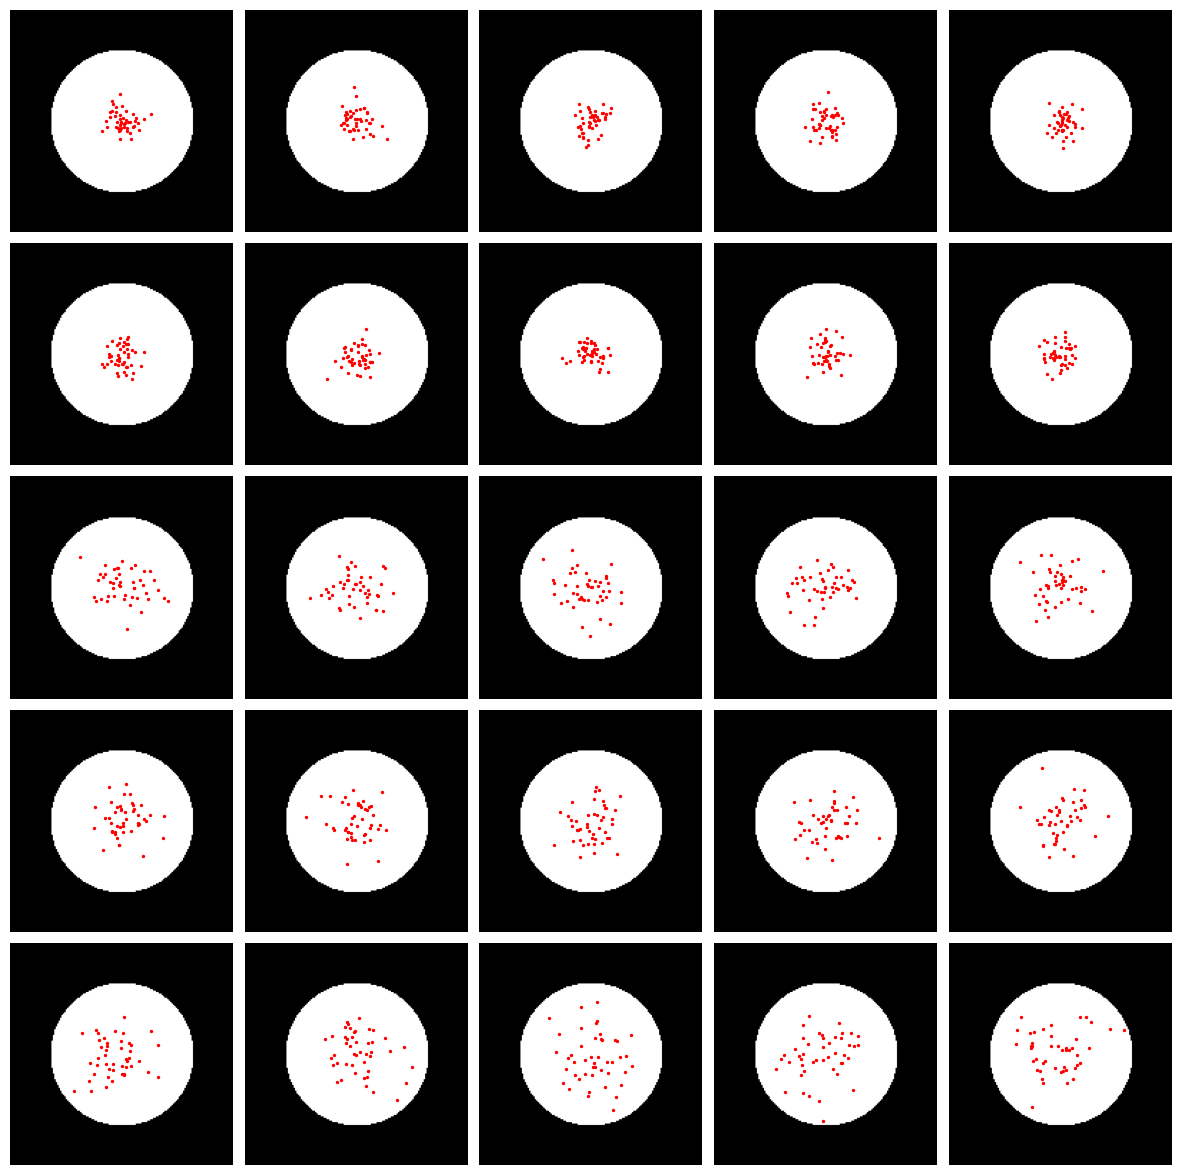

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse

# Image dimensions
height, width = 256, 256
center_y, center_x = height // 2, width // 2
a, b = 50, 50  # Major and minor axes

# Create a blank image
image = np.zeros((height, width), dtype=np.uint8)

# Generate ellipse
rr, cc = ellipse(center_y, center_x, b, a, shape=image.shape)
image[rr, cc] = 1

# Function to generate random spots using 2D Gaussian distribution
def generate_spots(mean, cov, num_samples=46):
    return np.random.multivariate_normal(mean, cov, num_samples)

# Mean at the center of the ellipse
mean = [center_x, center_y]

# Generate systematic covariance matrices
cov_matrices = []
for size in np.linspace(50, 1000, 10):
    for angle in np.linspace(0, np.pi, 10):
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        scale_matrix = np.diag([size, size])
        cov_matrix = rotation_matrix @ scale_matrix @ rotation_matrix.T
        cov_matrices.append(cov_matrix)

# Dictionaries to store the locations and parameters
locations_dict = {}
parameters_dict = {}

# Generate and store samples
index = 1
for repeat in range(100):
    for cov in cov_matrices:
        filtered_spots = []
        while len(filtered_spots) < 46:
            spots = generate_spots(mean, cov, num_samples=46)
            for spot in spots:
                y, x = spot
                if (x - center_x)**2 / a**2 + (y - center_y)**2 / b**2 <= 1:
                    filtered_spots.append(spot)
                if len(filtered_spots) == 46:
                    break
        
        locations_dict[f'distribution_{index}'] = np.array(filtered_spots[:46])
        parameters_dict[f'distribution_{index}'] = {'mean': mean, 'covariance': cov}
        index += 1

## Display example distributions
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    ax[i//5, i%5].imshow(image[50:206 ,50:206], cmap='gray')
    spots = locations_dict[f'distribution_{i+1}']
    ax[i//5, i%5].scatter(spots[:, 0]-50, spots[:, 1]-50, c='red', s=2)
    ax[i//5, i%5].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust as needed (smaller values reduce spacing)
plt.show()
# Save locations_dict and parameters_dict to files
import pickle
with open('/data/krishnendu/ripley_paper/generated_spots_25r/single_gaussian_locations_dict.pkl', 'wb') as f:
    pickle.dump(locations_dict, f)
with open('/data/krishnendu/ripley_paper/generated_spots_25r/single_gaussian_parameters_dict.pkl', 'wb') as f:
    pickle.dump(parameters_dict, f)


## 2-Mode GMM

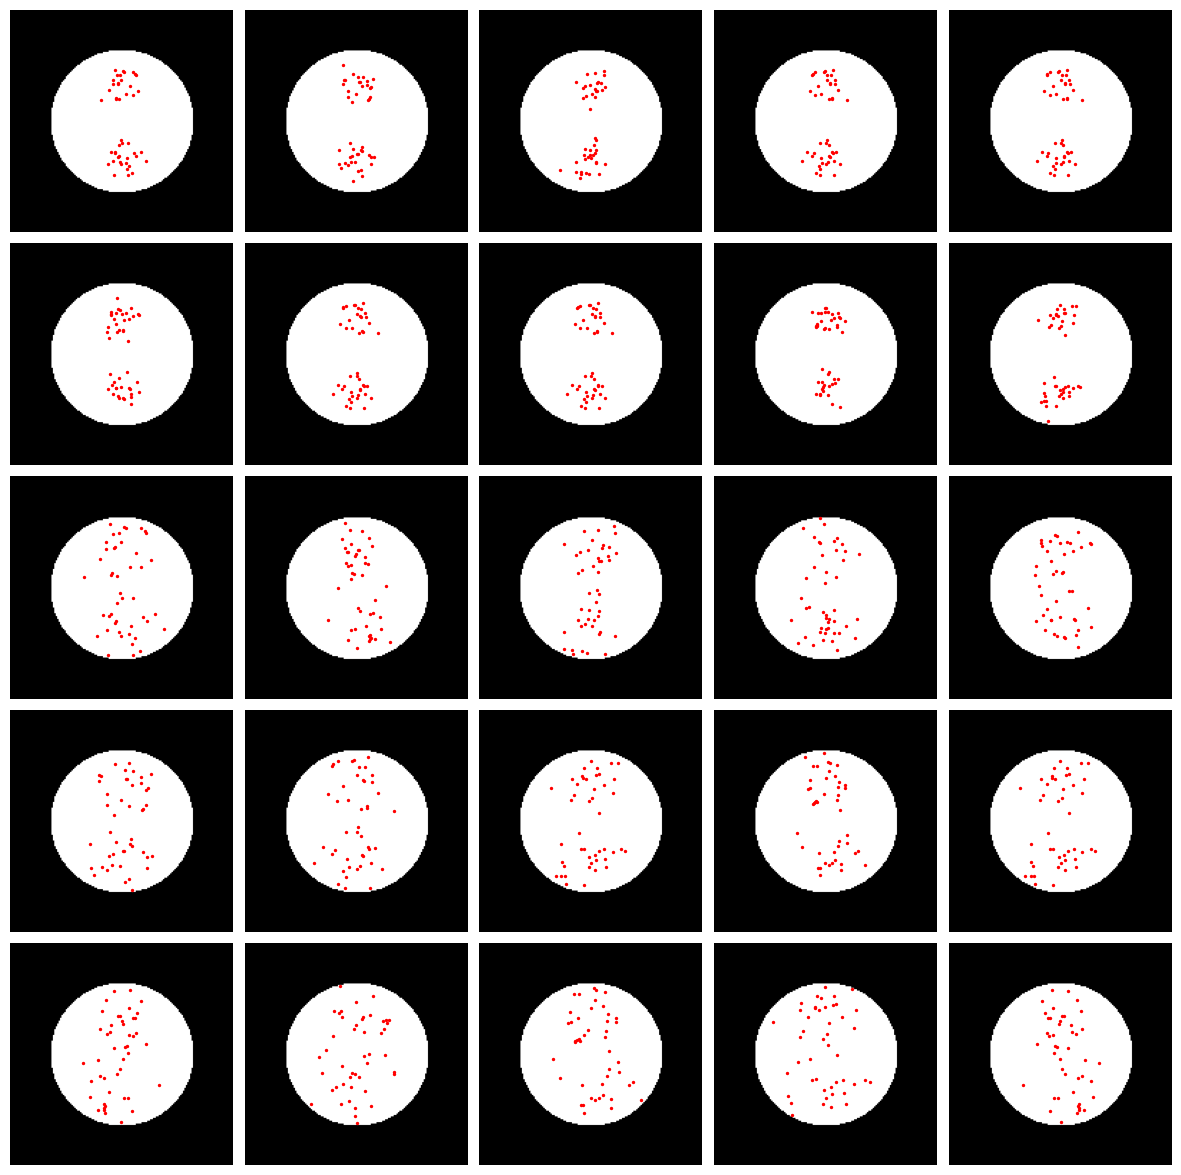

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse
from sklearn.mixture import GaussianMixture
import concurrent.futures
import pickle

# Image dimensions
height, width = 256, 256
center_y, center_x = height // 2, width // 2
a, b = 50, 50  # Major and minor axes

# Create a blank image
image = np.zeros((height, width), dtype=np.uint8)

# Generate ellipse
rr, cc = ellipse(center_y, center_x, b, a, shape=image.shape)
image[rr, cc] = 1

# Function to generate random spots using GMM with two Gaussians
def generate_spots_gmm(means, covariances, num_samples=46):
    weights = [0.5, 0.5]  # Similar amplitudes
    gmm = GaussianMixture(n_components=2, covariance_type='full')
    gmm.weights_ = np.array(weights)
    gmm.means_ = np.array(means)
    gmm.covariances_ = np.array(covariances)
    gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(gmm.covariances_))
    return gmm.sample(num_samples)[0]

# Generate systematic covariance matrices
cov_matrices = []
for size in np.linspace(50, 1000, 10):
    for angle in np.linspace(0, np.pi, 10):
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        scale_matrix = np.diag([size, size])
        cov_matrix = rotation_matrix @ scale_matrix @ rotation_matrix.T
        cov_matrices.append(cov_matrix)

# Generate systematic means with 50 units apart
mean_pairs = []
# for angle in np.linspace(0, 2 * np.pi, 36):
#     mean1_x = center_x + 25 * np.cos(angle)
#     mean1_y = center_y + 25 * np.sin(angle)
#     mean2_x = center_x + 25 * np.cos(angle + np.pi)
#     mean2_y = center_y + 25 * np.sin(angle + np.pi)
#     mean_pairs.append(([mean1_x, mean1_y], [mean2_x, mean2_y]))
mean_pairs.append(([128, 103], [128, 153]))

# Function to generate spots for a given mean pair and covariance matrix
def generate_and_filter_spots(index, mean_pair, cov_matrix):
    mean1, mean2 = mean_pair
    means = [mean1, mean2]
    covariances = [cov_matrix, cov_matrix]  # Same covariance matrix for both Gaussians
    filtered_spots = []
    while len(filtered_spots) < 46:
        spots = generate_spots_gmm(means, covariances, num_samples=46)
        for spot in spots:
            y, x = spot
            if (x - center_x)**2 / a**2 + (y - center_y)**2 / b**2 <= 1:
                filtered_spots.append(spot)
            if len(filtered_spots) == 46:
                break
    return index, np.array(filtered_spots[:46]), {'means': means, 'covariances': covariances}

# Prepare tasks for parallel execution
tasks = []
index = 1
for repeat in range(100):
    for mean_pair in mean_pairs:
        for cov_matrix in cov_matrices:
            tasks.append((index, mean_pair, cov_matrix))
            index += 1

# Dictionaries to store the locations and parameters
locations_dict = {}
parameters_dict = {}

# Execute tasks in parallel
with concurrent.futures.ProcessPoolExecutor(max_workers=64) as executor:
    futures = [executor.submit(generate_and_filter_spots, index, mean_pair, cov_matrix) for index, mean_pair, cov_matrix in tasks]
    for future in concurrent.futures.as_completed(futures):
        idx, spots, params = future.result()
        locations_dict[f'distribution_{idx}'] = spots
        parameters_dict[f'distribution_{idx}'] = params

# Display example distributions
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    ax[i//5, i%5].imshow(image[50:206 ,50:206], cmap='gray')
    spots = locations_dict[f'distribution_{i+1}']
    ax[i//5, i%5].scatter(spots[:, 0]-50, spots[:, 1]-50, c='red', s=2)
    ax[i//5, i%5].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust as needed (smaller values reduce spacing)
plt.show()
# Save locations_dict and parameters_dict to files
with open('/data/krishnendu/ripley_paper/generated_spots_25r/locations_dict_gmm_2modes.pkl', 'wb') as f:
    pickle.dump(locations_dict, f)
with open('/data/krishnendu/ripley_paper/generated_spots_25r/parameters_dict_gmm_2modes.pkl', 'wb') as f:
    pickle.dump(parameters_dict, f)


## 3-Mode GMM

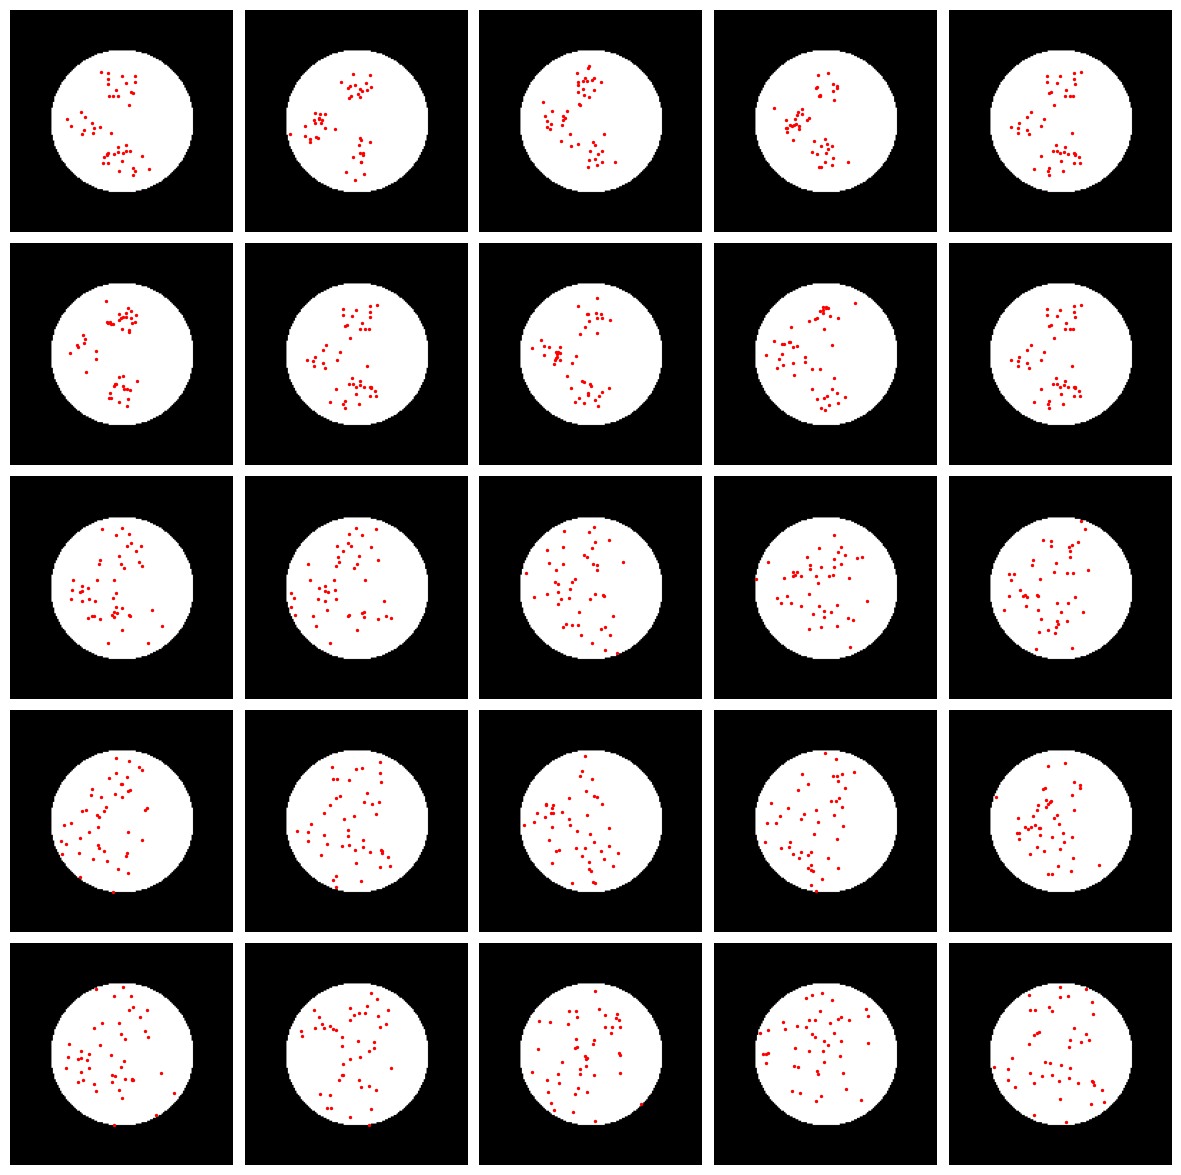

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse
from sklearn.mixture import GaussianMixture
import concurrent.futures
import pickle

# Image dimensions
height, width = 256, 256
center_y, center_x = height // 2, width // 2
a, b = 50, 50  # Major and minor axes

# Create a blank image
image = np.zeros((height, width), dtype=np.uint8)

# Generate ellipse
rr, cc = ellipse(center_y, center_x, b, a, shape=image.shape)
image[rr, cc] = 1

# Function to generate random spots using GMM with three Gaussians
def generate_spots_gmm(means, covariances, num_samples=46):
    weights = [1/3, 1/3, 1/3]  # Equal weights
    gmm = GaussianMixture(n_components=3, covariance_type='full')
    gmm.weights_ = np.array(weights)
    gmm.means_ = np.array(means)
    gmm.covariances_ = np.array(covariances)
    gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(gmm.covariances_))
    return gmm.sample(num_samples)[0]

# Generate systematic covariance matrices
cov_matrices = []
for size in np.linspace(50, 1000, 10):
    for angle in np.linspace(0, np.pi, 10):
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        scale_matrix = np.diag([size, size])
        cov_matrix = rotation_matrix @ scale_matrix @ rotation_matrix.T
        cov_matrices.append(cov_matrix)

# Generate systematic means with 40 units apart
mean_pairs = []
# for angle in np.linspace(0, 2 * np.pi, 12):  # 12 angles to cover the circle
#     mean1_x = center_x + 20 * np.cos(angle)
#     mean1_y = center_y + 20 * np.sin(angle)
#     mean2_x = center_x + 20 * np.cos(angle + 2 * np.pi / 3)
#     mean2_y = center_y + 20 * np.sin(angle + 2 * np.pi / 3)
#     mean3_x = center_x + 20 * np.cos(angle + 4 * np.pi / 3)
#     mean3_y = center_y + 20 * np.sin(angle + 4 * np.pi / 3)
#     mean_pairs.append(([mean1_x, mean1_y], [mean2_x, mean2_y], [mean3_x, mean3_y]))
mean_pairs.append(([128, 103], [128, 153], [103, 128]))

# Function to generate spots for a given mean pair and covariance matrix
def generate_and_filter_spots(index, mean_triplet, cov_matrix):
    mean1, mean2, mean3 = mean_triplet
    means = [mean1, mean2, mean3]
    covariances = [cov_matrix, cov_matrix, cov_matrix]  # Same covariance matrix for all Gaussians
    filtered_spots = []
    while len(filtered_spots) < 46:
        spots = generate_spots_gmm(means, covariances, num_samples=46)
        for spot in spots:
            y, x = spot
            if (x - center_x)**2 / a**2 + (y - center_y)**2 / b**2 <= 1:
                filtered_spots.append(spot)
            if len(filtered_spots) == 46:
                break
    return index, np.array(filtered_spots[:46]), {'means': means, 'covariances': covariances}

# Prepare tasks for parallel execution
tasks = []
index = 1
for repeat in range(100):
    for mean_triplet in mean_pairs:
        for cov_matrix in cov_matrices:
            tasks.append((index, mean_triplet, cov_matrix))
            index += 1

# Dictionaries to store the locations and parameters
locations_dict = {}
parameters_dict = {}

# Execute tasks in parallel
with concurrent.futures.ProcessPoolExecutor(max_workers=48) as executor:
    futures = [executor.submit(generate_and_filter_spots, index, mean_triplet, cov_matrix) for index, mean_triplet, cov_matrix in tasks]
    for future in concurrent.futures.as_completed(futures):
        idx, spots, params = future.result()
        locations_dict[f'distribution_{idx}'] = spots
        parameters_dict[f'distribution_{idx}'] = params

# Display example distributions
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    ax[i//5, i%5].imshow(image[50:206 ,50:206], cmap='gray')
    spots = locations_dict[f'distribution_{i+1}']
    ax[i//5, i%5].scatter(spots[:, 0]-50, spots[:, 1]-50, c='red', s=2)
    ax[i//5, i%5].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust as needed (smaller values reduce spacing)
plt.show()
# Save locations_dict and parameters_dict to files
with open('/data/krishnendu/ripley_paper/generated_spots_25r/locations_dict_gmm_3modes.pkl', 'wb') as f:
    pickle.dump(locations_dict, f)
with open('/data/krishnendu/ripley_paper/generated_spots_25r/parameters_dict_gmm_3modes.pkl', 'wb') as f:
    pickle.dump(parameters_dict, f)


In [ ]:
# Image dimensions
height, width = 256, 256
center_y, center_x = height // 2, width // 2
a, b = 25, 25  # Major and minor axes

# Create a blank image
image = np.zeros((height, width), dtype=np.uint8)

# Generate ellipse
rr, cc = ellipse(center_y, center_x, b, a, shape=image.shape)
image[rr, cc] = 1


rr1, cc1 = ellipse(center_y, center_x+32, 10, 10, shape=image.shape)
image[rr1, cc1] = 0
# Display the ellipse mask
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
# Image dimensions
height, width = 256, 256
center_y, center_x = height // 2, width // 2
a, b = 25, 25  # Major and minor axes

# Create a blank image
image = np.zeros((height, width), dtype=np.uint8)

# Generate ellipse
rr, cc = ellipse(center_y, center_x, b, a, shape=image.shape)
image[rr, cc] = 1

mean1, mean2 = mean_pair
image_1 = image.copy()
rr = 15
rr_m1, cc_m1 = ellipse(mean1[0], mean1[1], rr, rr, shape=image.shape)
image_1[rr_m1, cc_m1] = 0

rr_m2, cc_m2 = ellipse(mean2[0], mean2[1], rr, rr, shape=image.shape)
image_1[rr_m2, cc_m2] = 0

# Display the ellipse mask
plt.imshow(image_1, cmap='gray')
plt.axis('off')
plt.show()


## Single Gaussian with Nucleoli

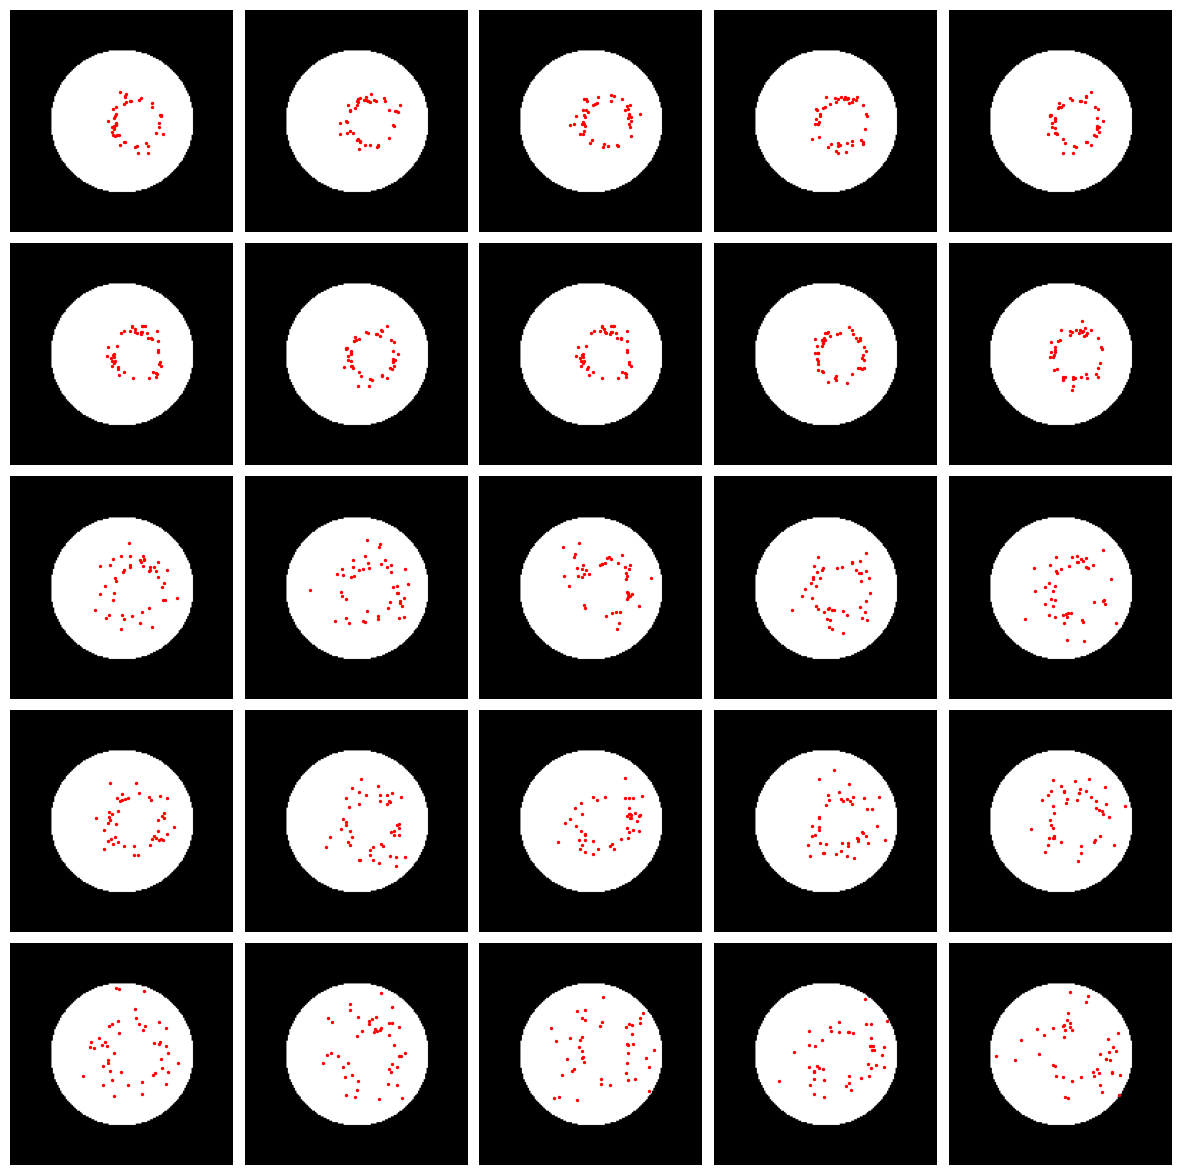

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse
from sklearn.mixture import GaussianMixture
import concurrent.futures
import pickle

# Image dimensions
height, width = 256, 256
center_y, center_x = height // 2, width // 2
a, b = 50, 50  # Major and minor axes

# Create a blank image
image = np.zeros((height, width), dtype=np.uint8)

# Generate ellipse
rr, cc = ellipse(center_y, center_x, b, a, shape=image.shape)
image[rr, cc] = 1

# Function to generate random spots using a single Gaussian
def generate_spots_gmm(mean, covariance, num_samples=46):
    gmm = GaussianMixture(n_components=1, covariance_type='full')
    gmm.weights_ = np.array([1.0])
    gmm.means_ = np.array([mean])
    gmm.covariances_ = np.array([covariance])
    gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(gmm.covariances_))
    return gmm.sample(num_samples)[0]

# Generate systematic covariance matrices
cov_matrices = []
for size in np.linspace(50, 1000, 10):
    for angle in np.linspace(0, np.pi, 10):
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        scale_matrix = np.diag([size, size])
        cov_matrix = rotation_matrix @ scale_matrix @ rotation_matrix.T
        cov_matrices.append(cov_matrix)

# Generate systematic means with 50 units apart
means = []
for angle in [0]:
    mean_x = center_x + 10 * np.cos(angle)
    mean_y = center_y + 10 * np.sin(angle)
    means.append([mean_x, mean_y])

# Function to generate spots for a given mean and covariance matrix
def generate_and_filter_spots(index, mean, cov_matrix):
    image_1 = image.copy()
    rr, cc = ellipse(mean[0], mean[1], 15, 15, shape=image.shape)
    image_1[rr, cc] = 0

    filtered_spots = []
    while len(filtered_spots) < 46:
        spots = generate_spots_gmm(mean, cov_matrix, num_samples=46)
        for spot in spots:
            y, x = int(spot[0]), int(spot[1])  # Convert to integers
            if 0 <= y < image_1.shape[0] and 0 <= x < image_1.shape[1] and image_1[y, x] > 0:
                filtered_spots.append(spot)
            if len(filtered_spots) == 46:
                break
    return index, np.array(filtered_spots[:46]), {'mean': mean, 'covariance': cov_matrix}

# Prepare tasks for parallel execution
tasks = []
index = 1
for repeat in range(100):
    for mean in means:
        for cov_matrix in cov_matrices:
            tasks.append((index, mean, cov_matrix))
            index += 1

# Dictionaries to store the locations and parameters
locations_dict = {}
parameters_dict = {}

# Execute tasks in parallel
with concurrent.futures.ProcessPoolExecutor(max_workers=64) as executor:
    futures = [executor.submit(generate_and_filter_spots, index, mean, cov_matrix) for index, mean, cov_matrix in tasks]
    for future in concurrent.futures.as_completed(futures):
        idx, spots, params = future.result()
        locations_dict[f'distribution_{idx}'] = spots
        parameters_dict[f'distribution_{idx}'] = params

# Display example distributions
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    ax[i//5, i%5].imshow(image[50:206 ,50:206], cmap='gray')
    spots = locations_dict[f'distribution_{i+1}']
    ax[i//5, i%5].scatter(spots[:, 0]-50, spots[:, 1]-50, c='red', s=2)
    ax[i//5, i%5].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust as needed (smaller values reduce spacing)
plt.show()
# Save locations_dict and parameters_dict to files
with open('/data/krishnendu/ripley_paper/generated_spots_25r/locations_dict_single_gaussian_with_nucleoli.pkl', 'wb') as f:
    pickle.dump(locations_dict, f)
with open('/data/krishnendu/ripley_paper/generated_spots_25r/parameters_dict_single_gaussian_with_nucleoli.pkl', 'wb') as f:
    pickle.dump(parameters_dict, f)


## 2-Mode GMM with Nucleoli

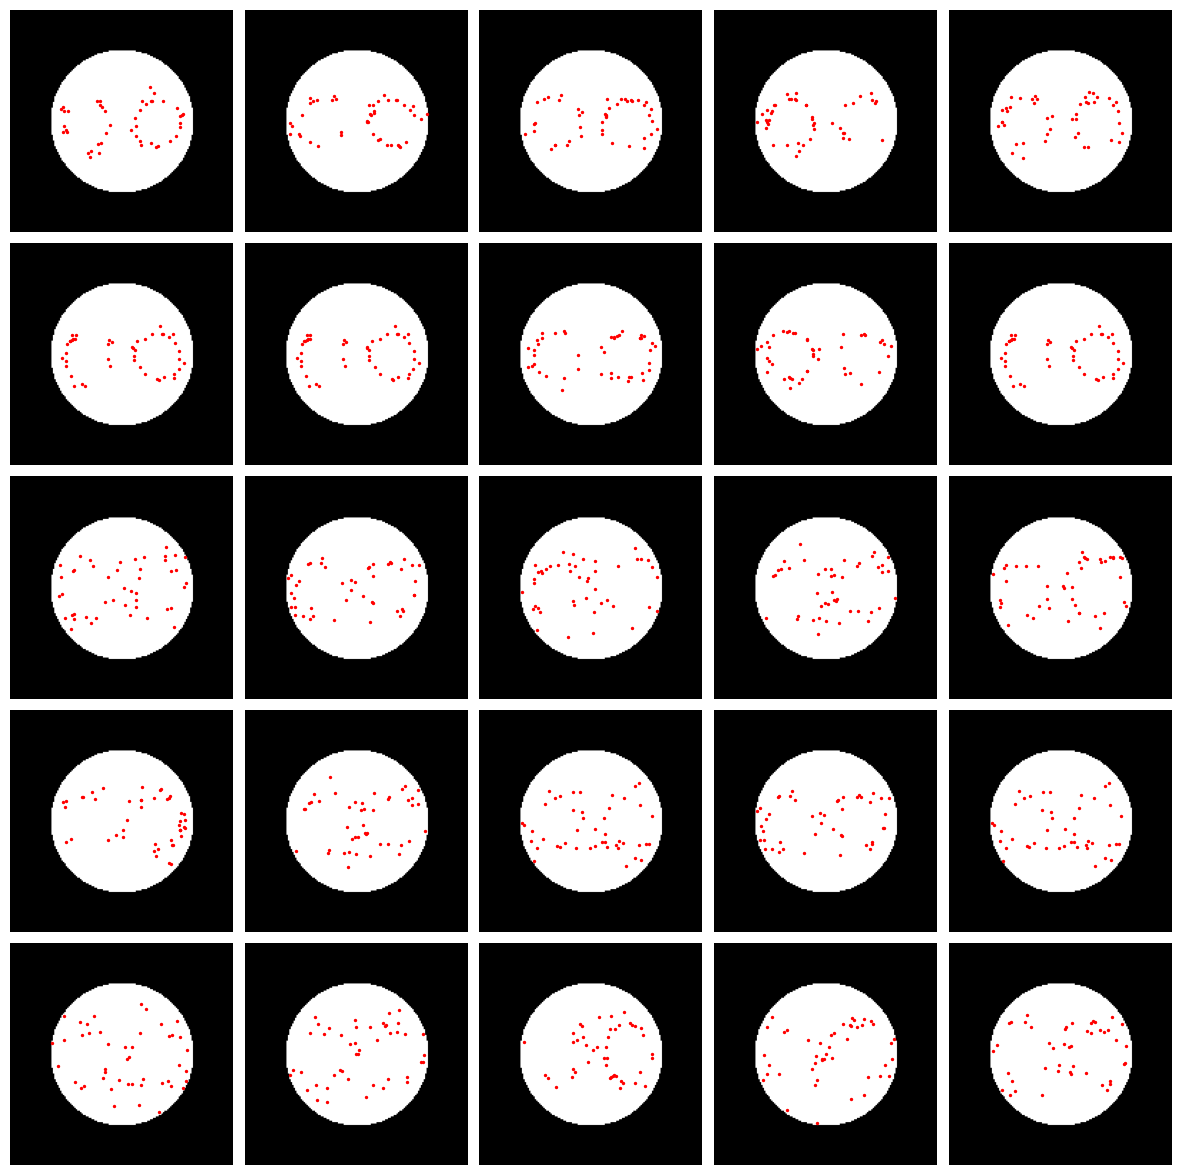

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse
from sklearn.mixture import GaussianMixture
import concurrent.futures
import pickle

# Image dimensions
height, width = 256, 256
center_y, center_x = height // 2, width // 2
a, b = 50, 50  # Major and minor axes

# Create a blank image
image = np.zeros((height, width), dtype=np.uint8)

# Generate ellipse
rr, cc = ellipse(center_y, center_x, b, a, shape=image.shape)
image[rr, cc] = 1

# Function to generate random spots using GMM with two Gaussians
def generate_spots_gmm(means, covariances, num_samples=46):
    weights = [0.5, 0.5]  # Similar amplitudes
    gmm = GaussianMixture(n_components=2, covariance_type='full')
    gmm.weights_ = np.array(weights)
    gmm.means_ = np.array(means)
    gmm.covariances_ = np.array(covariances)
    gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(gmm.covariances_))
    return gmm.sample(num_samples)[0]

# Generate systematic covariance matrices
cov_matrices = []
for size in np.linspace(50, 1000, 10):
    for angle in np.linspace(0, np.pi, 10):
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        scale_matrix = np.diag([size, size])
        cov_matrix = rotation_matrix @ scale_matrix @ rotation_matrix.T
        cov_matrices.append(cov_matrix)

# Generate systematic means with 50 units apart
mean_pairs = []
for angle in [0]:
    mean1_x = center_x + 25 * np.cos(angle)
    mean1_y = center_y + 25 * np.sin(angle)
    mean2_x = center_x + 25 * np.cos(angle + np.pi)
    mean2_y = center_y + 25 * np.sin(angle + np.pi)
    mean_pairs.append(([mean1_x, mean1_y], [mean2_x, mean2_y]))
    
    

# Function to generate spots for a given mean pair and covariance matrix
def generate_and_filter_spots(index, mean_pair, cov_matrix):
    mean1, mean2 = mean_pair
    image_1 = image.copy()
    rr = 15
    rr_m1, cc_m1 = ellipse(mean1[0], mean1[1], rr, rr, shape=image.shape)
    image_1[rr_m1, cc_m1] = 0

    rr_m2, cc_m2 = ellipse(mean2[0], mean2[1], rr, rr, shape=image.shape)
    image_1[rr_m2, cc_m2] = 0

    means = [mean1, mean2]
    covariances = [cov_matrix, cov_matrix]  # Same covariance matrix for both Gaussians
    filtered_spots = []
    while len(filtered_spots) < 46:
        spots = generate_spots_gmm(means, covariances, num_samples=46)
        for spot in spots:
            y, x = int(spot[0]), int(spot[1])  # Convert to integers
            if 0 <= y < image_1.shape[0] and 0 <= x < image_1.shape[1] and image_1[y, x] > 0:
                filtered_spots.append(spot)
            if len(filtered_spots) == 46:
                break
    return index, np.array(filtered_spots[:46]), {'means': means, 'covariances': covariances}

# Prepare tasks for parallel execution
tasks = []
index = 1
for repeat in range(100):
    for mean_pair in mean_pairs:
        for cov_matrix in cov_matrices:
            tasks.append((index, mean_pair, cov_matrix))
            index += 1

# Dictionaries to store the locations and parameters
locations_dict = {}
parameters_dict = {}

# Execute tasks in parallel
with concurrent.futures.ProcessPoolExecutor(max_workers=64) as executor:
    futures = [executor.submit(generate_and_filter_spots, index, mean_pair, cov_matrix) for index, mean_pair, cov_matrix in tasks]
    for future in concurrent.futures.as_completed(futures):
        idx, spots, params = future.result()
        locations_dict[f'distribution_{idx}'] = spots
        parameters_dict[f'distribution_{idx}'] = params

# Display example distributions
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    ax[i//5, i%5].imshow(image[50:206 ,50:206], cmap='gray')
    spots = locations_dict[f'distribution_{i+1}']
    ax[i//5, i%5].scatter(spots[:, 0]-50, spots[:, 1]-50, c='red', s=2)
    ax[i//5, i%5].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust as needed (smaller values reduce spacing)
plt.show()
#Save locations_dict and parameters_dict to files
with open('/data/krishnendu/ripley_paper/generated_spots_25r/locations_dict_gmm_2modes_with_nucleoli.pkl', 'wb') as f:
    pickle.dump(locations_dict, f)
with open('/data/krishnendu/ripley_paper/generated_spots_25r/parameters_dict_gmm_2modes_with_nucleoli.pkl', 'wb') as f:
    pickle.dump(parameters_dict, f)


## Two adjacent spots

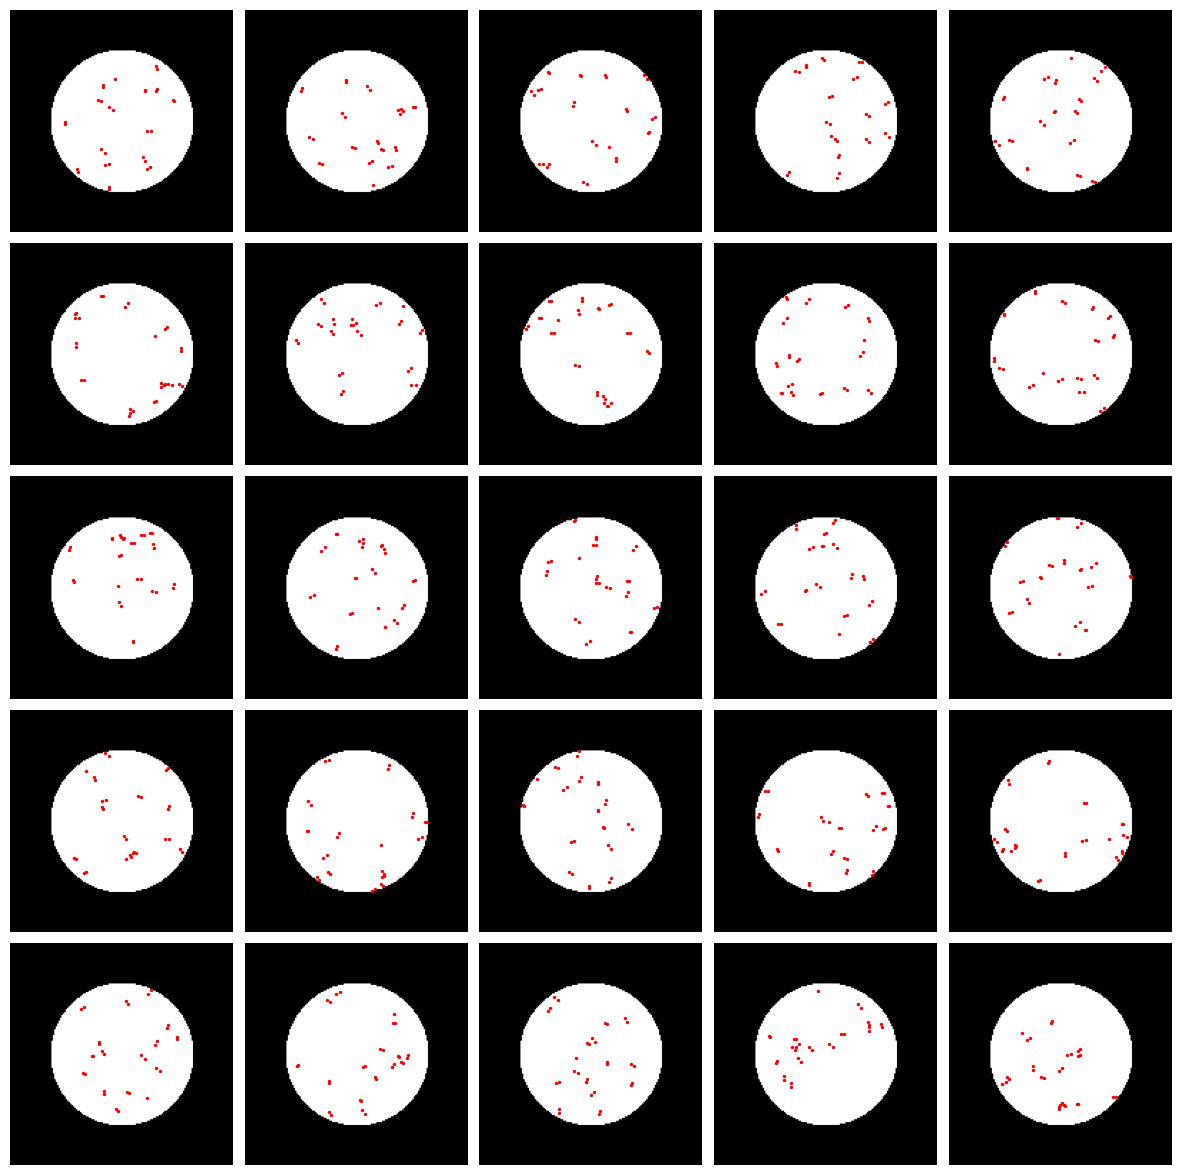

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse
import pickle

# Image dimensions
height, width = 256, 256
center_y, center_x = height // 2, width // 2
a, b = 50, 50  # Major and minor axes

# Create a blank image
image = np.zeros((height, width), dtype=np.uint8)

# Generate ellipse
rr, cc = ellipse(center_y, center_x, b, a, shape=image.shape)
image[rr, cc] = 1

# Function to generate random spots using a uniform distribution within an ellipse
def generate_spots_ellipse(num_samples=16):
    spots = []
    while len(spots) < num_samples:
        x = np.random.uniform(center_x - a, center_x + a)
        y = np.random.uniform(center_y - b, center_y + b)
        if (x - center_x)**2 / a**2 + (y - center_y)**2 / b**2 <= 1:
            spots.append([x, y])
    return np.array(spots)

# Function to generate perturbed spots within the ellipse
def generate_perturbed_spots_within_ellipse(spots, epsilon_range=(-3, 3)):
    perturbed_spots = []
    for spot in spots:
        valid = False
        while not valid:
            eps_x = np.random.uniform(epsilon_range[0], epsilon_range[1])
            eps_y = np.random.uniform(epsilon_range[0], epsilon_range[1])
            new_spot = [spot[0] + eps_x, spot[1] + eps_y]
            if ((new_spot[0] - center_x)**2 / a**2 + (new_spot[1] - center_y)**2 / b**2 <= 1):
                perturbed_spots.append(new_spot)
                valid = True
    return np.array(perturbed_spots)

# Dictionaries to store the locations and parameters
locations_dict = {}
parameters_dict = {}

# Generate and store samples
index = 1
for repeat in range(100):
    for _ in range(10):  # Adjust as needed for number of samples per repeat
        initial_spots = generate_spots_ellipse(num_samples=16)
        perturbed_spots = generate_perturbed_spots_within_ellipse(initial_spots[:15])  # Only perturb the first 15 spots
        combined_spots = np.vstack((initial_spots, perturbed_spots))
        locations_dict[f'distribution_{index}'] = combined_spots
        parameters_dict[f'distribution_{index}'] = {'shape': 'ellipse', 'num_samples': 46}
        index += 1

# Display example distributions
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    ax[i//5, i%5].imshow(image[50:206 ,50:206], cmap='gray')
    spots = locations_dict[f'distribution_{i+1}']
    ax[i//5, i%5].scatter(spots[:, 0]-50, spots[:, 1]-50, c='red', s=2)
    ax[i//5, i%5].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust as needed (smaller values reduce spacing)
plt.show()

# Save locations_dict and parameters_dict to files
with open('/data/krishnendu/ripley_paper/generated_spots_25r/uniform_2adj_spot_locations_dict.pkl', 'wb') as f:
    pickle.dump(locations_dict, f)
with open('/data/krishnendu/ripley_paper/generated_spots_25r/uniform_2adj_spot_parameters_dict.pkl', 'wb') as f:
    pickle.dump(parameters_dict, f)


## Three adjacent spots

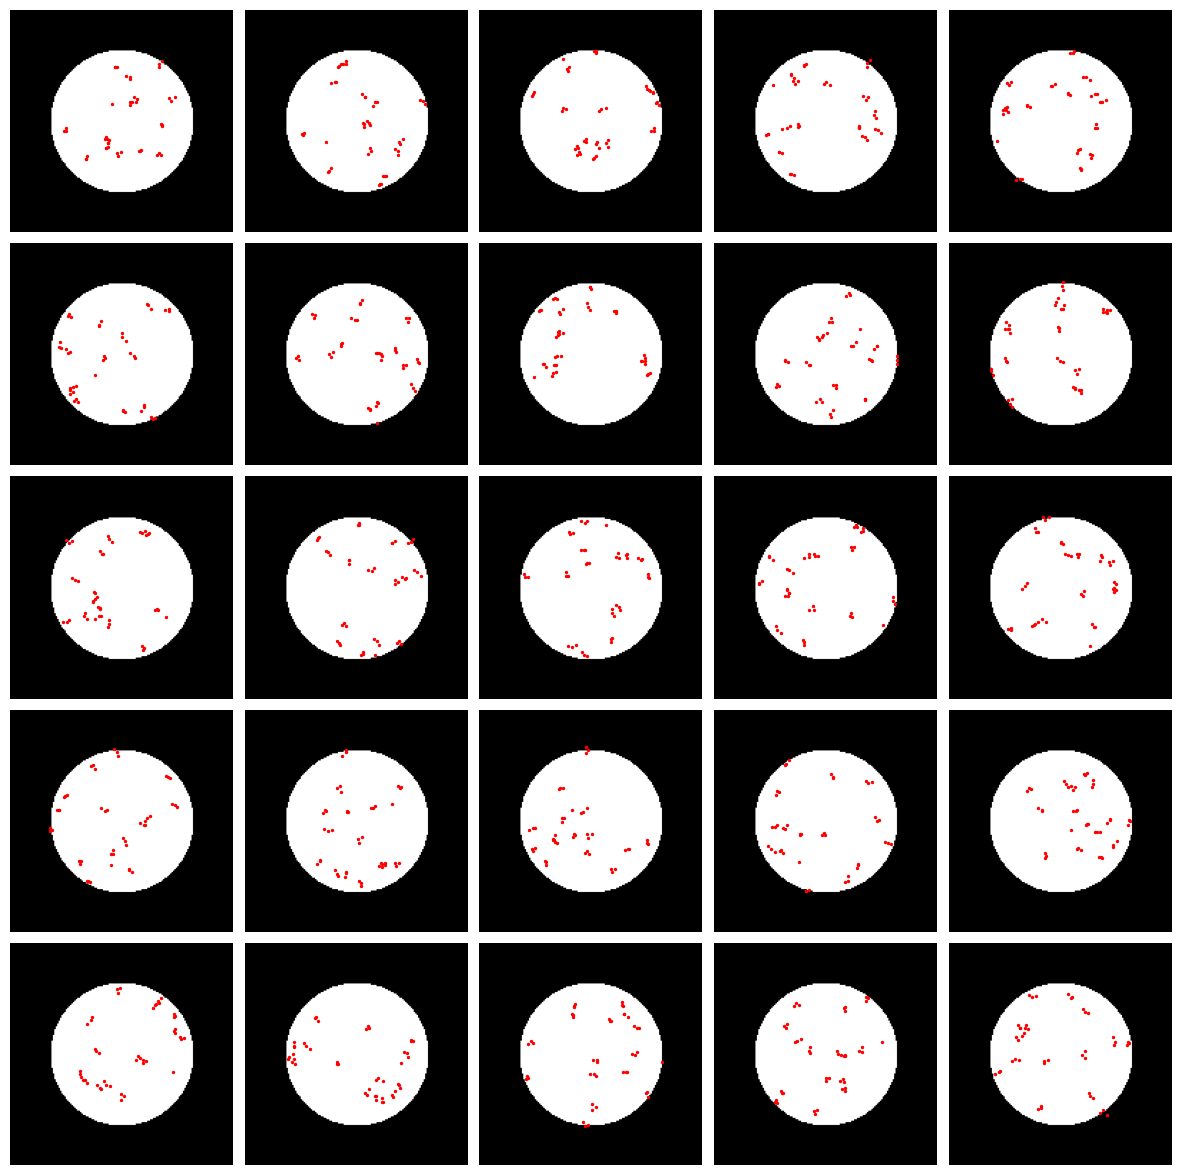

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse
import pickle

# Image dimensions
height, width = 256, 256
center_y, center_x = height // 2, width // 2
a, b = 50, 50  # Major and minor axes

# Create a blank image
image = np.zeros((height, width), dtype=np.uint8)

# Generate ellipse
rr, cc = ellipse(center_y, center_x, b, a, shape=image.shape)
image[rr, cc] = 1

# Function to generate random spots using a uniform distribution within an ellipse
def generate_spots_ellipse(num_samples=16):
    spots = []
    while len(spots) < num_samples:
        x = np.random.uniform(center_x - a, center_x + a)
        y = np.random.uniform(center_y - b, center_y + b)
        if (x - center_x)**2 / a**2 + (y - center_y)**2 / b**2 <= 1:
            spots.append([x, y])
    return np.array(spots)

# Function to generate perturbed spots
def generate_perturbed_spots(spots, epsilon_range=(-3, 3)):
    perturbed_spots = []
    for spot in spots:
        for _ in range(2):  # Generate 2 perturbed spots for each initial spot
            eps_x = np.random.uniform(epsilon_range[0], epsilon_range[1])
            eps_y = np.random.uniform(epsilon_range[0], epsilon_range[1])
            new_spot = [spot[0] + eps_x, spot[1] + eps_y]
            perturbed_spots.append(new_spot)
    return np.array(perturbed_spots)

# Dictionaries to store the locations and parameters
locations_dict = {}
parameters_dict = {}

# Generate and store samples
index = 1
for repeat in range(100):
    for _ in range(10):  # Adjust as needed for number of samples per repeat
        initial_spots = generate_spots_ellipse(num_samples=16)
        perturbed_spots = generate_perturbed_spots(initial_spots[:15])  # Only perturb the first 15 spots
        combined_spots = np.vstack((initial_spots, perturbed_spots))
        locations_dict[f'distribution_{index}'] = combined_spots
        parameters_dict[f'distribution_{index}'] = {'shape': 'ellipse', 'num_samples': 46}
        index += 1

# Display example distributions
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    ax[i//5, i%5].imshow(image[50:206 ,50:206], cmap='gray')
    spots = locations_dict[f'distribution_{i+1}']
    ax[i//5, i%5].scatter(spots[:, 0]-50, spots[:, 1]-50, c='red', s=2)
    ax[i//5, i%5].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust as needed (smaller values reduce spacing)
plt.show()

# Save locations_dict and parameters_dict to files
with open('/data/krishnendu/ripley_paper/generated_spots_25r/uniform_3adj_spot_locations_dict.pkl', 'wb') as f:
    pickle.dump(locations_dict, f)
with open('/data/krishnendu/ripley_paper/generated_spots_25r/uniform_3adj_spot_parameters_dict.pkl', 'wb') as f:
    pickle.dump(parameters_dict, f)

In [ ]:
## 

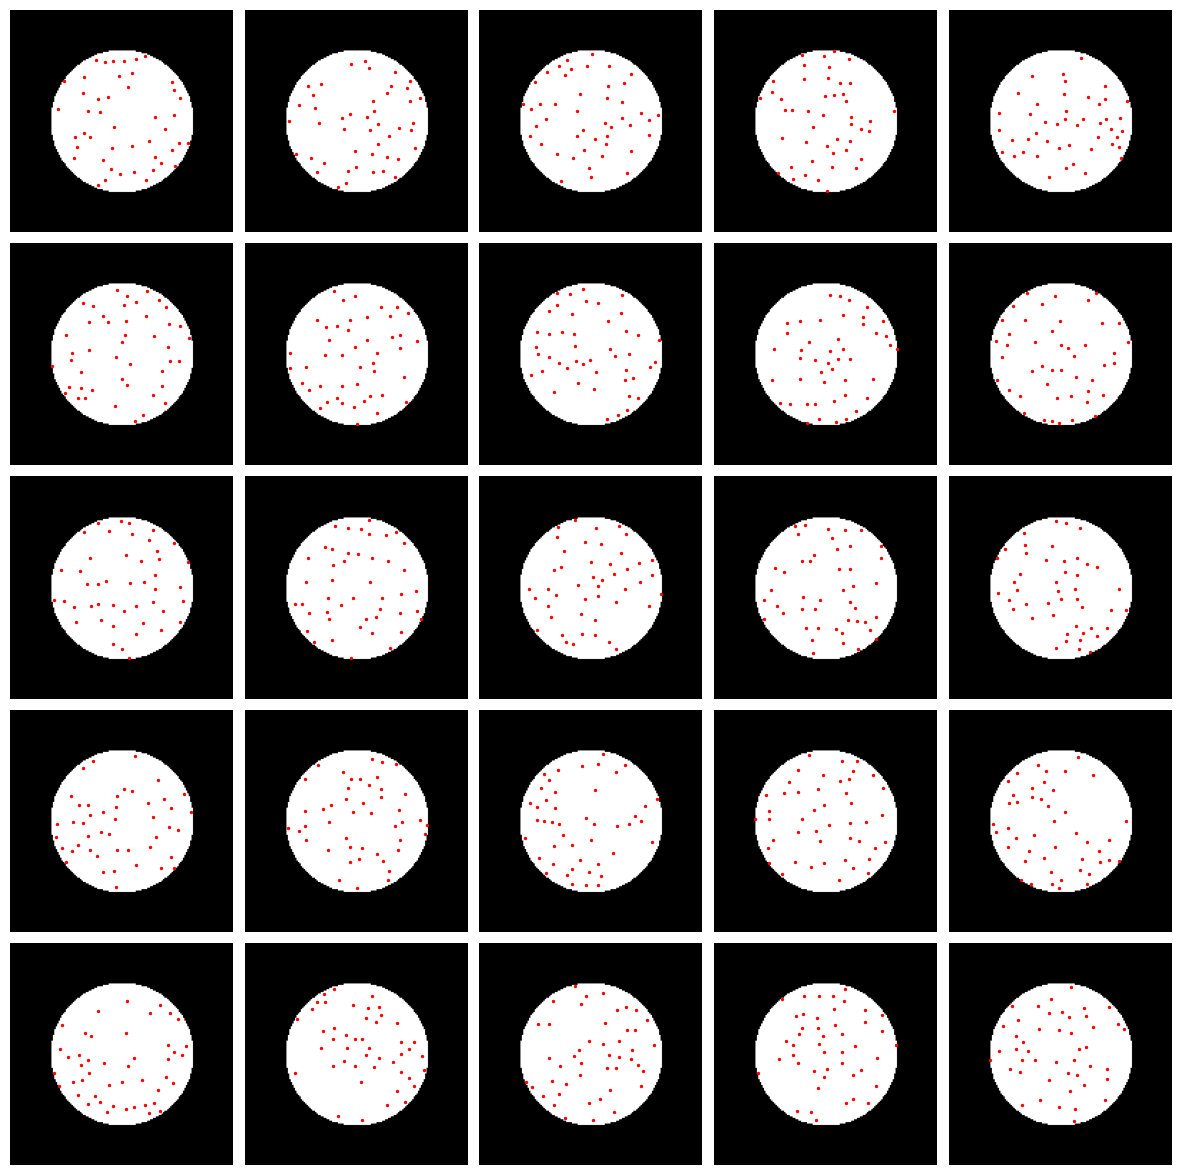

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse
import pickle

# Image dimensions
height, width = 256, 256
center_y, center_x = height // 2, width // 2
a, b = 50, 50  # Major and minor axes

# Create a blank image
image = np.zeros((height, width), dtype=np.uint8)

# Generate ellipse
rr, cc = ellipse(center_y, center_x, b, a, shape=image.shape)
image[rr, cc] = 1

# Function to generate dispersed spots using Poisson-disk sampling within an ellipse
def generate_dispersed_spots_ellipse(num_samples=46, min_dist=10):
    spots = []
    while len(spots) < num_samples:
        candidate = np.random.uniform(low=[center_x - a, center_y - b], high=[center_x + a, center_y + b])
        if (candidate[0] - center_x)**2 / a**2 + (candidate[1] - center_y)**2 / b**2 <= 1:
            if all(np.linalg.norm(candidate - np.array(s)) >= min_dist for s in spots):
                spots.append(candidate)
    return np.array(spots)

# Dictionaries to store the locations and parameters
locations_dict = {}
parameters_dict = {}

# Generate and store samples
index = 1
for repeat in range(100):
    for _ in range(10):  # Adjust as needed for number of samples per repeat
        spots = generate_dispersed_spots_ellipse(num_samples=46, min_dist=5)
        locations_dict[f'distribution_{index}'] = spots
        parameters_dict[f'distribution_{index}'] = {'shape': 'ellipse', 'num_samples': 46, 'min_dist': 10}
        index += 1

# Display example distributions
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    ax[i//5, i%5].imshow(image[50:206 ,50:206], cmap='gray')
    spots = locations_dict[f'distribution_{i+1}']
    ax[i//5, i%5].scatter(spots[:, 0]-50, spots[:, 1]-50, c='red', s=2)
    ax[i//5, i%5].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust as needed (smaller values reduce spacing)
plt.show()

# Save locations_dict and parameters_dict to files
with open('/data/krishnendu/ripley_paper/generated_spots_25r/dispersed_locations_dict.pkl', 'wb') as f:
    pickle.dump(locations_dict, f)
with open('/data/krishnendu/ripley_paper/generated_spots_25r/dispersed_parameters_dict.pkl', 'wb') as f:
    pickle.dump(parameters_dict, f)
